<a href="https://colab.research.google.com/github/remidion/PGM-Project/blob/main/Timeliness_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/remidion/PGM-Project/blob/main/main.ipynb)

In [4]:
# Imports
from getpass import getpass
import pandas as pd
import os
import numpy as np
import glob
import datetime
import matplotlib
import matplotlib.pyplot as plt

In [5]:
!pip install geopandas
import geopandas as gpd

In [6]:
if os.path.exists('PGM-Project'):
  !git -C PGM-Project/ pull
else:
  u = input('GitHub username: ')
  p = getpass('GitHub password: ')
  !git clone https://$u:$p@github.com/remidion/PGM-Project.git
  del u, p

Already up to date.


# Data Preparation

## Download MBTA Data

In [7]:
if not os.path.exists("data"):
  !wget https://www.arcgis.com/sharing/rest/content/items/d685ba39d9a54d908f49a2a762a9eb47/data
if not os.path.exists("MBTA Bus Arrival Departure Aug-Sept 2018.csv"):
  !unzip data

if not os.path.exists("data.1"):
  !wget https://www.arcgis.com/sharing/rest/content/items/1bd340b39942438685d8dcdfe3f26d1a/data
if not os.path.exists("MBTA Bus Arrival Departure Apr-June 2019.csv"):
  !unzip data.1

--2020-12-10 17:49:30--  https://www.arcgis.com/sharing/rest/content/items/d685ba39d9a54d908f49a2a762a9eb47/data
Resolving www.arcgis.com (www.arcgis.com)... 34.233.149.104, 18.234.22.251, 18.234.22.28, ...
Connecting to www.arcgis.com (www.arcgis.com)|34.233.149.104|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ago-item-storage.s3.us-east-1.amazonaws.com/d685ba39d9a54d908f49a2a762a9eb47/MBTA_Bus_Arrival_Departure_Times_2018.zip?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEOL%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJGMEQCIEwCIeKMv%2BZNIXAsmfSPUnt%2BubnBzmuwt5QtSIRjl1CaAiBYV1EAyLiC4%2B1ElvVkWxdLezElMtY7stMr6XBA6r%2FpFiq0Awh6EAAaDDYwNDc1ODEwMjY2NSIMhgIXMluglm01rok5KpEDPBxqwXw36g3TdlcXuZEWLEm5uIDw774HF7%2FeCkSEv3zzbhBCDWe1ufT5M5Jz9Vh3sU9llv25fRZn0AY%2B9VBAELwKu7L4pGll8ZHhhIf8MG2Zf2iHbV1eJWBjbdtEOMD2YYHodDut7PpWnCzLVuNd3p3T%2BrGgsu20t%2F7F9XYDlivQgVcPqvz5pd9QSQ6%2FyMwSK0ZLTLYodPrWbXRzlD3nkLzWZhQzUrkE%2F%2FXkY%2B1Di67G%2BXuSMPLotTDfKRWLKyGUPHtUbbbqUgs

## Load MBTA Arrival Data

In [8]:
df2 = pd.read_csv("MBTA Bus Arrival Departure Apr-June 2019.csv")
df2

,service_date,route_id,direction,half_trip_id,stop_id,stop_name,stop_sequence,point_type,standard_type,scheduled,actual,scheduled_headway,headway
0,2019-04-01,01,Inbound,42976988.0,75,mit,4.0,Midpoint,Schedule,1900-01-01 05:19:00,1900-01-01 05:21:20,NaN,NaN
1,2019-04-01,01,Inbound,42976988.0,79,hynes,5.0,Midpoint,Schedule,1900-01-01 05:23:00,1900-01-01 05:24:17,NaN,NaN
2,2019-04-01,01,Inbound,42976988.0,187,masta,6.0,Midpoint,Schedule,1900-01-01 05:25:00,1900-01-01 05:26:05,NaN,NaN
3,2019-04-01,01,Inbound,42976988.0,59,Wasma,7.0,Midpoint,Schedule,1900-01-01 05:29:00,1900-01-01 05:27:59,NaN,NaN
4,2019-04-01,01,Inbound,42977170.0,110,hhgat,1.0,Startpoint,Headway,1900-01-01 05:30:00,1900-01-01 05:29:55,1200.0,1230.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7670643,2019-06-30,SL5,Outbound,44045095.0,15176,mawor,8.0,Midpoint,Headway,1900-01-02 00:54:00,NaN,900.0,NaN
7670644,2019-06-30,SL5,Outbound,44045095.0,55,Wasma,9.0,Midpoint,Headway,1900-01-02 00:55:00,NaN,900.0,NaN
7670645,2019-06-30,SL5,Outbound,44045095.0,60,Walen,10.0,Midpoint,Headway,1900-01-02 00:56:00,NaN,900.0,NaN
7670646,2019-06-30,SL5,Outbound,44045095.0,61,Melwa,11.0,Midpoint,Headway,1900-01-02 00:57:00,NaN,900.0,NaN


## Utility functions

In [9]:
def filter_on_row_col(df, target_rows, target_columns):
  for key, value in target_rows:
      df.drop(df[df[key] != value].index, inplace=True)
  df.drop(df.columns.difference(target_columns), axis=1, inplace=True)

def load_targets_from_csvs(target_columns, target_rows):
  bus_arrival_files = glob.glob('./*.csv')

  df_cumulative = pd.DataFrame()
  for f in bus_arrival_files:
    df_tmp = pd.read_csv(f)
    filter_on_row_col(df_tmp, target_rows, target_columns)
    df_cumulative = df_cumulative.append(df_tmp)
    print(f"Loaded {f}")
    del df_tmp

  return df_cumulative

# EDA on Routes Timeliness

In [10]:
df2 = load_targets_from_csvs(target_columns=['route_id','direction','stop_id'], target_rows=[])

Loaded ./MBTA Bus Arrival Departure Apr-June 2019.csv
Loaded ./MBTA Bus Arrival Departure Oct-Dec 2018.csv
Loaded ./MBTA Bus Arrival Departure Oct-Dec 2019.csv
Loaded ./MBTA Bus Arrival Departure Jul-Sept 2019.csv
Loaded ./MBTA Bus Arrival Departure Jan-Mar 2019.csv
Loaded ./MBTA Bus Arrival Departure Aug-Sept 2018.csv


In [29]:
### To store dataframe ###
#compression_opts = dict(method='zip', archive_name='df2.csv')  
#df2.to_csv('PGM-Project/data/df2.zip', index=False, compression=compression_opts) 
#df2.to_csv('PGM-Project/data/df2.csv')

## ZIP:  22Mb
## CSV: 700Mb

In [11]:
# Calculate visits per stop
group = df2[['route_id','direction','stop_id']].groupby(['route_id','direction'])
unique_stops = group.nunique().rename(columns={"stop_id":"unique_stop_ids"})
total_stops = pd.DataFrame(group.size()).rename(columns={0:"total_stops"})
stops = pd.merge(unique_stops, total_stops, left_index=True, right_index=True)
stops['visits_per_stop'] = stops['total_stops'] / stops['unique_stop_ids']

In [12]:
stops.sort_values('visits_per_stop', ascending=False).head(20)

unique_stop_ids  total_stops  visits_per_stop
route_id direction                                               
SL5      Outbound                12       814194     67849.500000
         Inbound                 13       872944     67149.538462
111      Inbound                 12       777438     64786.500000
SL1      Outbound                 7       448292     64041.714286
31       Outbound                 5       304750     60950.000000
         Inbound                  5       300727     60145.400000
SL2      Outbound                 6       345890     57648.333333
         Inbound                  6       335191     55865.166667
111      Outbound                13       718718     55286.000000
23       Inbound                 10       549635     54963.500000
SL1      Inbound                 13       709980     54613.846154
01       Outbound                 9       488393     54265.888889
         Inbound                  9       472691     52521.222222
39       Inbound                 11       561718     51065.272727
28       Inbound                 11       552235     50203.181818
39       Outbound                10       496903     49690.300000
743      Outbound                11       544599     49509.000000
77       Outbound                11       538967     48997.000000
         Inbound                 11       536599     48781.727273
23       Outbound                12       548555     45712.916667

# Preprocess data

Loading the data for a single route and a single direction

In [13]:
target_columns = ["service_date", "half_trip_id", "stop_id", "stop_sequence", "scheduled", "actual"]
target_rows = [('route_id', '01'),('direction', 'Inbound')]
df3 = load_targets_from_csvs(target_columns, target_rows)

Loaded ./MBTA Bus Arrival Departure Apr-June 2019.csv
Loaded ./MBTA Bus Arrival Departure Oct-Dec 2018.csv
Loaded ./MBTA Bus Arrival Departure Oct-Dec 2019.csv
Loaded ./MBTA Bus Arrival Departure Jul-Sept 2019.csv
Loaded ./MBTA Bus Arrival Departure Jan-Mar 2019.csv
Loaded ./MBTA Bus Arrival Departure Aug-Sept 2018.csv


In [28]:
compression_opts = dict(method='zip', archive_name='df3.csv')  
df3.to_csv('PGM-Project/data/df3.zip', index=False, compression=compression_opts) 
#df3.to_csv('PGM-Project/data/df3.csv')


Comment:
stop_id and stop_sequence are not always consistent in the dataframe!

In [14]:
group = df3.groupby(by=['stop_id', 'stop_sequence']).size()
print(group)

stop_id  stop_sequence
59       5.0                  1
         6.0                  3
         7.0              42083
62       1.0                  2
         6.0                  1
         7.0                  3
         8.0              42080
64       1.0                180
         2.0                  2
         7.0                  1
         8.0                  3
         9.0              42079
67       1.0                  3
         2.0              42069
72       1.0                  1
         2.0                  3
         3.0              42069
75       2.0                  1
         3.0                  3
         4.0              42083
79       3.0                  1
         4.0                  3
         5.0              42083
110      1.0              42070
187      4.0                  1
         5.0                  3
         6.0              42083
dtype: int64


Create a definition of valid stop IDs, based on the frequency of occurence

In [15]:
valid_stop_ids = group[group > group.max()/2]
sequence_to_id = valid_stop_ids.index.to_frame().reset_index(drop=True).sort_values(['stop_sequence']).set_index(['stop_id'])
print(sequence_to_id)
sequence_to_id = sequence_to_id['stop_sequence'].to_dict()

         stop_sequence
stop_id               
110                1.0
67                 2.0
72                 3.0
75                 4.0
79                 5.0
187                6.0
59                 7.0
62                 8.0
64                 9.0


Drop invalid (out of sequence) stop IDs

In [16]:
df3['expected_stop_sequence'] = df3['stop_id'].apply(lambda x: sequence_to_id[x])
df3.drop(df3[((df3['expected_stop_sequence'] != df3['stop_sequence']) | (df3['stop_sequence'].isna()))].index, axis=0, inplace=True)
df3.drop('expected_stop_sequence', axis=1, inplace=True)

Pivot data frame

In [17]:
df4 = df3.pivot(index=['service_date', 'half_trip_id'], columns=['stop_sequence'], values=['scheduled',	'actual'])

Drop incomplete routes

In [18]:
df5 = df4[df4.isna().sum(axis=1) == 0]

## Transform data

In [19]:
# Transform to datetime
time_format = '%Y-%m-%d %H:%M:%S'
df5 = df5.applymap(lambda x: datetime.datetime.strptime(x, time_format))

# Transform to seconds from day start
since = datetime.datetime(1900, 1, 1, 0, 0)
df6 = df5.applymap(lambda x: (x - since).total_seconds() )
df6

scheduled           ...   actual         
stop_sequence                   1.0      2.0  ...      8.0      9.0
service_date half_trip_id                     ...                  
2018-08-02   40135101.0     18600.0  18780.0  ...  20237.0  20260.0
             40135103.0     22860.0  23040.0  ...  24607.0  24637.0
             40135105.0     27840.0  28140.0  ...  30965.0  31031.0
             40135121.0     25560.0  25800.0  ...  27733.0  27781.0
             40135155.0     21960.0  22140.0  ...  24049.0  24092.0
...                             ...      ...  ...      ...      ...
2019-09-30   45106583.0     59040.0  59340.0  ...  62147.0  62196.0
             45106585.0     66780.0  67080.0  ...  68912.0  68983.0
             45106587.0     72660.0  72900.0  ...  74723.0  74759.0
             45106589.0     77580.0  77820.0  ...  79203.0  79224.0
             45108654.0     65880.0  66180.0  ...  68440.0  68503.0

[37203 rows x 18 columns]

In [20]:
# Create 'timeliness' metric (seconds early or late)
df7 = df6[('actual',)].loc[:] - df6[('scheduled',)].loc[:]
columns = [('timeliness', col) for col in df7.columns]
df7.columns = pd.MultiIndex.from_tuples(columns, names=[None, 'stop_sequence'])

In [21]:
# Create timeliness dataframe
df8 = pd.concat([df6, df7], axis=1, sort=False)
df8.drop('actual', axis=1, level=0, inplace=True)
df8['route_start_time'] = df5[("scheduled", 1.0)]
df8 = df8.reset_index().set_index(["service_date", "route_start_time"])
# df8.drop('scheduled', axis=1, level=0, inplace=True)
df8.drop('half_trip_id', axis=1, level=0, inplace=True)
df8 = df8.sort_index()
df8

scheduled           ... timeliness       
stop_sequence                          1.0      2.0  ...        8.0    9.0
service_date route_start_time                        ...                  
2018-08-02   1900-01-01 05:10:00   18600.0  18780.0  ...      317.0  280.0
             1900-01-01 05:30:00   19800.0  19980.0  ...      377.0  353.0
             1900-01-01 05:50:00   21000.0  21180.0  ...      471.0  438.0
             1900-01-01 06:06:00   21960.0  22140.0  ...      769.0  752.0
             1900-01-01 06:21:00   22860.0  23040.0  ...       67.0   37.0
...                                    ...      ...  ...        ...    ...
2019-09-30   1900-01-01 23:40:00   85200.0  85380.0  ...      207.0   18.0
             1900-01-01 23:54:00   86040.0  86220.0  ...      225.0   10.0
             1900-01-02 00:22:00   87720.0  87900.0  ...      -75.0 -296.0
             1900-01-02 00:37:00   88620.0  88800.0  ...       76.0 -142.0
             1900-01-02 00:52:00   89520.0  89700.0  ...      -55.0 -274.0

[37203 rows x 18 columns]

In [30]:
compression_opts = dict(method='zip', archive_name='df8.csv')  
df8.to_csv('PGM-Project/data/df8.zip', index=False, compression=compression_opts) 
#df8.to_csv('PGM-Project/data/df8.csv')

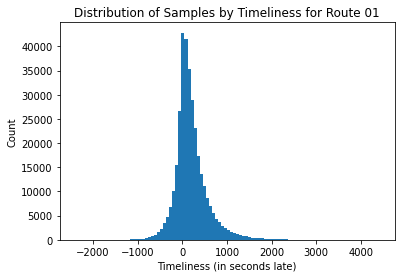

In [22]:
# Sanity check
plt.hist(df8['timeliness'].to_numpy().flatten(), bins=100)
plt.title('Distribution of Samples by Timeliness for Route 01')
plt.xlabel('Timeliness (in seconds late)')
plt.ylabel('Count')
plt.show()

In [23]:
#print(stats.describe(adj.sum(axis=0)))
#print(np.max(adj.sum(axis=0)),np.max(adj.sum(axis=1)))

def histogram(m=None, x='', y='', xbin=None, ybin=None, log=True, directed=True, yonly=False):
  if x is None: x = np.ravel(m.sum(axis=0))
  if y is None: y = np.ravel(m.sum(axis=1))   

  
  #print(x.shape,x[x>0].shape)

  #apply log-scale
  def rm0(x):
    for i, v in enumerate(x):
      if v ==0: x[i] = 0.1
    return x
  if log:
    x = np.log10(rm0(x))
    y = np.log10(rm0(y))
  #print(x.shape,y.shape)

  xmin = np.min(x)
  xmax = np.max(x)
  ymin = np.min(y)
  ymax = np.max(y)

  #xbins=int(np.ceil(xmax))*5
  #ybins=int(np.ceil(ymax))*5
  xbins=ybins=20
  #print(xmax, xbins)
  #print(ymax, ybins)


  #_,_,_, ax = plt.hist2d(adj.sum(axis=0),adj.sum(axis=1), bins=[13, 19])
  if m is not None:
    if not directed:
      xcoord = np.append(m[:,0], m[:,1])
      ycoord = np.append(m[:,1], m[:,0])
    else:
      xcoord = m[:,0]
      ycoord = m[:,1]
    
    ax, _,_ = np.histogram2d(ycoord, xcoord, bins=(ybins,xbins))

    # Define the locations for the axes
    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width+0.02
    
    # Set up the geometry of the three plots
    side_height=0.2
    rect_main = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left+.015, bottom_h, width-.03,side_height] # dimensions of x-histogram
    rect_histy = [left_h, bottom, side_height, height] # dimensions of y-histogram
    
    # Set up the size of the figure
    fig = plt.figure(1, figsize=(9.5,9))
    
    # Make the three plots
    axHist2d = plt.axes(rect_main) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram
    #Plot the histograms
    aspectratio = 1.0*(xmax - 0)/(1.0*ymax - 0)

    _ = axHist2d.imshow(ax, extent=[xmin,xmax,ymin,ymax],
          interpolation='nearest', origin='lower',aspect=aspectratio)
    axHistx.hist(x, bins=xbins, color = 'blue', log=True)
    axHisty.hist(y, bins=ybins, orientation='horizontal', color = 'red', log=True)
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    #axHisty.xaxis.set_major_locator(MaxNLocator(4))
    #axHistx.yaxis.set_major_locator(MaxNLocator(4))

    plt.show()

  if not yonly:
    print('Histogram of X')
    plt.hist(x, log=True)
    #plt.xscale('log')
    axes = plt.gca()
    #axes.set_xlim([xmin,np.ceil(xmax)])
    plt.show()
    plt.cla()

  #print('Histogram of Y')
  plt.hist(y, log=True)
  #plt.xscale('log')
  axes = plt.gca()
  #axes.set_xlim([ymin,np.ceil(ymax)])
  plt.show()


data_ = df8['timeliness'].to_numpy()
histogram(data_, x = np.ravel(data_.sum(axis=0)), y = np.ravel(data_.sum(axis=1)),log=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


ValueError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f35b5769bf8> (for post_execute):


ValueError: ignored

ValueError: ignored

In [ ]:
# Transform continuous to discrete
df9 = df8[('scheduled',)]
df10 = df8[('timeliness',)].apply(lambda x: pd.cut(x, bins=[-np.inf,-60,240,np.inf], labels=['Early', 'On Time', 'Late']), axis=0).astype('category')
df11 = pd.concat([df9, df10], axis=1, keys=['scheduled', 'timeliness'])
df11

scheduled                             \
stop_sequence                          1.0      2.0      3.0      4.0   
service_date route_start_time                                           
2018-08-02   1900-01-01 05:10:00   18600.0  18780.0  18960.0  19140.0   
             1900-01-01 05:30:00   19800.0  19980.0  20160.0  20340.0   
             1900-01-01 05:50:00   21000.0  21180.0  21360.0  21540.0   
             1900-01-01 06:06:00   21960.0  22140.0  22320.0  22500.0   
             1900-01-01 06:21:00   22860.0  23040.0  23220.0  23400.0   
...                                    ...      ...      ...      ...   
2019-09-30   1900-01-01 23:40:00   85200.0  85380.0  85560.0  85860.0   
             1900-01-01 23:54:00   86040.0  86220.0  86400.0  86700.0   
             1900-01-02 00:22:00   87720.0  87900.0  88080.0  88380.0   
             1900-01-02 00:37:00   88620.0  88800.0  88980.0  89280.0   
             1900-01-02 00:52:00   89520.0  89700.0  89880.0  90180.0   

                                                                               \
stop_sequence                         5.0      6.0      7.0      8.0      9.0   
service_date route_start_time                                                   
2018-08-02   1900-01-01 05:10:00  19320.0  19500.0  19680.0  19920.0  19980.0   
             1900-01-01 05:30:00  20520.0  20700.0  20880.0  21120.0  21180.0   
             1900-01-01 05:50:00  21720.0  21900.0  22080.0  22320.0  22380.0   
             1900-01-01 06:06:00  22680.0  22860.0  23040.0  23280.0  23340.0   
             1900-01-01 06:21:00  23700.0  23940.0  24120.0  24540.0  24600.0   
...                                   ...      ...      ...      ...      ...   
2019-09-30   1900-01-01 23:40:00  86100.0  86280.0  86520.0  86760.0  87000.0   
             1900-01-01 23:54:00  86940.0  87120.0  87360.0  87600.0  87840.0   
             1900-01-02 00:22:00  88620.0  88800.0  89040.0  89280.0  89520.0   
             1900-01-02 00:37:00  89520.0  89700.0  89940.0  90180.0  90420.0   
             1900-01-02 00:52:00  90420.0  90600.0  90840.0  91080.0  91320.0   

                                 timeliness                             \
stop_sequence                           1.0      2.0      3.0      4.0   
service_date route_start_time                                            
2018-08-02   1900-01-01 05:10:00    On Time  On Time  On Time     Late   
             1900-01-01 05:30:00    On Time  On Time  On Time     Late   
             1900-01-01 05:50:00    On Time  On Time  On Time  On Time   
             1900-01-01 06:06:00    On Time  On Time  On Time  On Time   
             1900-01-01 06:21:00    On Time  On Time  On Time  On Time   
...                                     ...      ...      ...      ...   
2019-09-30   1900-01-01 23:40:00    On Time  On Time  On Time  On Time   
             1900-01-01 23:54:00    On Time     Late     Late  On Time   
             1900-01-02 00:22:00       Late     Late     Late  On Time   
             1900-01-02 00:37:00    On Time  On Time  On Time  On Time   
             1900-01-02 00:52:00    On Time  On Time  On Time  On Time   

                                                                               
stop_sequence                         5.0      6.0      7.0      8.0      9.0  
service_date route_start_time                                                  
2018-08-02   1900-01-01 05:10:00     Late     Late     Late     Late     Late  
             1900-01-01 05:30:00     Late     Late     Late     Late     Late  
             1900-01-01 05:50:00  On Time  On Time     Late     Late     Late  
             1900-01-01 06:06:00     Late     Late     Late     Late     Late  
             1900-01-01 06:21:00  On Time  On Time  On Time  On Time  On Time  
...                                   ...      ...      ...      ...      ...  
2019-09-30   1900-01-01 23:40:00  On Time  On Time  On Time  On Time  On Time  
             1900-01-01 23:54:00  On T

## Align on Bins

In [ ]:
# Get only critical information
df13 = df11['scheduled'].reset_index()[['service_date', 'route_start_time']]
df13 = df13.rename_axis(None, axis=1)

In [ ]:
# Try filtering on weekdays
day_format = '%Y-%m-%d'
is_weekday = df13['service_date'].apply(lambda x: datetime.datetime.strptime(x, day_format).isoweekday() <= 5)
df14 = df13[is_weekday]
df14

,service_date,route_start_time
0,2018-08-02,1900-01-01 05:10:00
1,2018-08-02,1900-01-01 05:30:00
2,2018-08-02,1900-01-01 05:50:00
3,2018-08-02,1900-01-01 06:06:00
4,2018-08-02,1900-01-01 06:21:00
...,...,...
37198,2019-09-30,1900-01-01 23:40:00
37199,2019-09-30,1900-01-01 23:54:00
37200,2019-09-30,1900-01-02 00:22:00
37201,2019-09-30,1900-01-02 00:37:00


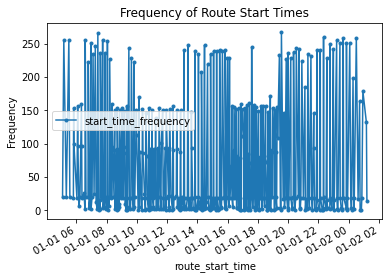

In [ ]:
group = df14.groupby('route_start_time', as_index=False).count().rename(columns={'service_date':'start_time_frequency'}).sort_values(by='route_start_time')
group.plot(x='route_start_time', y='start_time_frequency', marker='.', title='Frequency of Route Start Times', ylabel='Frequency');

In [ ]:
# Create bins
bins_start_time = datetime.datetime(1900, 1, 1, 6, 0)
bins_end_time = datetime.datetime(1900, 1, 2, 1, 0)
bin_delta_mins = 30 # 60 must be divisible by value
bin_delta = datetime.timedelta(minutes=bin_delta_mins)
n_bins = (bins_end_time - bins_start_time) // bin_delta

bins = [bins_start_time + n * bin_delta for n in range(n_bins)]
bins_df = pd.DataFrame(bins, columns=['route_start_time'])
bins_df['cross_join'] = 0
bins_df

,route_start_time,cross_join
0,1900-01-01 06:00:00,0
1,1900-01-01 06:30:00,0
2,1900-01-01 07:00:00,0
3,1900-01-01 07:30:00,0
4,1900-01-01 08:00:00,0
5,1900-01-01 08:30:00,0
6,1900-01-01 09:00:00,0
7,1900-01-01 09:30:00,0
8,1900-01-01 10:00:00,0
9,1900-01-01 10:30:00,0


In [ ]:
dates_df = pd.DataFrame(df14['service_date'].unique(), columns=['service_date'])
dates_df['cross_join'] = 0
dates_df

,service_date,cross_join
0,2018-08-02,0
1,2018-08-03,0
2,2018-08-06,0
3,2018-08-07,0
4,2018-08-08,0
...,...,...
292,2019-09-24,0
293,2019-09-25,0
294,2019-09-26,0
295,2019-09-27,0


In [ ]:
df15 = dates_df.merge(bins_df, on='cross_join').drop(columns='cross_join')
# df15.columns = [('time', col) for col in df15.columns]
df15  

,service_date,route_start_time
0,2018-08-02,1900-01-01 06:00:00
1,2018-08-02,1900-01-01 06:30:00
2,2018-08-02,1900-01-01 07:00:00
3,2018-08-02,1900-01-01 07:30:00
4,2018-08-02,1900-01-01 08:00:00
...,...,...
11281,2019-09-30,1900-01-01 22:30:00
11282,2019-09-30,1900-01-01 23:00:00
11283,2019-09-30,1900-01-01 23:30:00
11284,2019-09-30,1900-01-02 00:00:00


In [ ]:
# Round to nearest time delta
df20 = df11.reset_index()#.droplevel(level=1,axis=1)#[['service_date', 'route_start_time']]
df20.columns = df20.columns.to_flat_index()
df20['route_bin'] = df20[('route_start_time','')]#.apply(lambda x: datetime.datetime.strptime(x, time_format))
df20['route_bin'] = df20['route_bin'].apply(lambda x: x - datetime.timedelta(minutes=x.minute % bin_delta_mins))
df20

,"(service_date, )","(route_start_time, )","(scheduled, 1.0)","(scheduled, 2.0)","(scheduled, 3.0)","(scheduled, 4.0)","(scheduled, 5.0)","(scheduled, 6.0)","(scheduled, 7.0)","(scheduled, 8.0)",...,"(timeliness, 1.0)","(timeliness, 2.0)","(timeliness, 3.0)","(timeliness, 4.0)","(timeliness, 5.0)","(timeliness, 6.0)","(timeliness, 7.0)","(timeliness, 8.0)","(timeliness, 9.0)",route_bin
0,2018-08-02,1900-01-01 05:10:00,18600.0,18780.0,18960.0,19140.0,19320.0,19500.0,19680.0,19920.0,...,On Time,On Time,On Time,Late,Late,Late,Late,Late,Late,1900-01-01 05:00:00
1,2018-08-02,1900-01-01 05:30:00,19800.0,19980.0,20160.0,20340.0,20520.0,20700.0,20880.0,21120.0,...,On Time,On Time,On Time,Late,Late,Late,Late,Late,Late,1900-01-01 05:30:00
2,2018-08-02,1900-01-01 05:50:00,21000.0,21180.0,21360.0,21540.0,21720.0,21900.0,22080.0,22320.0,...,On Time,On Time,On Time,On Time,On Time,On Time,Late,Late,Late,1900-01-01 05:30:00
3,2018-08-02,1900-01-01 06:06:00,21960.0,22140.0,22320.0,22500.0,22680.0,22860.0,23040.0,23280.0,...,On Time,On Time,On Time,On Time,Late,Late,Late,Late,Late,1900-01-01 06:00:00
4,2018-08-02,1900-01-01 06:21:00,22860.0,23040.0,23220.0,23400.0,23700.0,23940.0,24120.0,24540.0,...,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,1900-01-01 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37198,2019-09-30,1900-01-01 23:40:00,85200.0,85380.0,85560.0,85860.0,86100.0,86280.0,86520.0,86760.0,...,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,1900-01-01 23:30:00
37199,2019-09-30,1900-01-01 23:54:00,86040.0,86220.0,86400.0,86700.0,86940.0,87120.0,87360.0,87600.0,...,On Time,Late,Late,On Time,On Time,Late,On Time,On Time,On Time,1900-01-01 23:30:00
37200,2019-09-30,1900-01-02 00:22:00,87720.0,87900.0,88080.0,88380.0,88620.0,88800.0,89040.0,89280.0,...,Late,Late,Late,On Time,On Time,On Time,On Time,Early,Early,1900-01-02 00:00:00
37201,2019-09-30,1900-01-02 00:37:00,88620.0,88800.0,88980.0,89280.0,89520.0,89700.0,89940.0,90180.0,...,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,Early,1900-01-02 00:30:00


In [ ]:
df21 = df20.drop_duplicates(subset=[('service_date',''),'route_bin'])#[['service_date','route_bin']]
df21.head(10)

,"(service_date, )","(route_start_time, )","(scheduled, 1.0)","(scheduled, 2.0)","(scheduled, 3.0)","(scheduled, 4.0)","(scheduled, 5.0)","(scheduled, 6.0)","(scheduled, 7.0)","(scheduled, 8.0)",...,"(timeliness, 1.0)","(timeliness, 2.0)","(timeliness, 3.0)","(timeliness, 4.0)","(timeliness, 5.0)","(timeliness, 6.0)","(timeliness, 7.0)","(timeliness, 8.0)","(timeliness, 9.0)",route_bin
0,2018-08-02,1900-01-01 05:10:00,18600.0,18780.0,18960.0,19140.0,19320.0,19500.0,19680.0,19920.0,...,On Time,On Time,On Time,Late,Late,Late,Late,Late,Late,1900-01-01 05:00:00
1,2018-08-02,1900-01-01 05:30:00,19800.0,19980.0,20160.0,20340.0,20520.0,20700.0,20880.0,21120.0,...,On Time,On Time,On Time,Late,Late,Late,Late,Late,Late,1900-01-01 05:30:00
3,2018-08-02,1900-01-01 06:06:00,21960.0,22140.0,22320.0,22500.0,22680.0,22860.0,23040.0,23280.0,...,On Time,On Time,On Time,On Time,Late,Late,Late,Late,Late,1900-01-01 06:00:00
5,2018-08-02,1900-01-01 06:35:00,23700.0,23940.0,24120.0,24360.0,24660.0,24900.0,25080.0,25500.0,...,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,1900-01-01 06:30:00
8,2018-08-02,1900-01-01 07:06:00,25560.0,25800.0,25980.0,26220.0,26520.0,26760.0,26940.0,27420.0,...,On Time,On Time,On Time,Late,Late,Late,Late,Late,Late,1900-01-01 07:00:00
11,2018-08-02,1900-01-01 07:44:00,27840.0,28140.0,28500.0,28800.0,29100.0,29460.0,29760.0,30240.0,...,On Time,On Time,On Time,Late,Late,Late,Late,Late,Late,1900-01-01 07:30:00
13,2018-08-03,1900-01-01 05:10:00,18600.0,18780.0,18960.0,19140.0,19320.0,19500.0,19680.0,19920.0,...,On Time,On Time,On Time,On Time,On Time,Early,Early,Early,Early,1900-01-01 05:00:00
14,2018-08-03,1900-01-01 05:30:00,19800.0,19980.0,20160.0,20340.0,20520.0,20700.0,20880.0,21120.0,...,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,1900-01-01 05:30:00
16,2018-08-03,1900-01-01 06:06:00,21960.0,22140.0,22320.0,22500.0,22680.0,22860.0,23040.0,23280.0,...,Early,Early,Early,On Time,On Time,On Time,On Time,On Time,On Time,1900-01-01 06:00:00
18,2018-08-03,1900-01-01 06:35:00,23700.0,23940.0,24120.0,24360.0,24660.0,24900.0,25080.0,25500.0,...,On Time,On Time,On Time,Late,Late,Late,Late,Late,Late,1900-01-01 06:30:00


In [ ]:
# Merge on the bins that we're using
# NA will fill bins with no data

df22 = df15.merge(df21[[('service_date',''),'route_bin']], how='left', left_on=['service_date', 'route_start_time'], right_on=[('service_date',''), 'route_bin'])
# df22['service_date'] = ~df22['service_date'].isna()
df22

C:\Users\Alex\anaconda3\envs\pgm_env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,service_date,route_start_time,"(service_date, )",route_bin
0,2018-08-02,1900-01-01 06:00:00,2018-08-02,1900-01-01 06:00:00
1,2018-08-02,1900-01-01 06:30:00,2018-08-02,1900-01-01 06:30:00
2,2018-08-02,1900-01-01 07:00:00,2018-08-02,1900-01-01 07:00:00
3,2018-08-02,1900-01-01 07:30:00,2018-08-02,1900-01-01 07:30:00
4,2018-08-02,1900-01-01 08:00:00,NaN,NaT
...,...,...,...,...
11281,2019-09-30,1900-01-01 22:30:00,2019-09-30,1900-01-01 22:30:00
11282,2019-09-30,1900-01-01 23:00:00,2019-09-30,1900-01-01 23:00:00
11283,2019-09-30,1900-01-01 23:30:00,2019-09-30,1900-01-01 23:30:00
11284,2019-09-30,1900-01-02 00:00:00,2019-09-30,1900-01-02 00:00:00


In [ ]:
df23 = df22.pivot(index=['service_date'], columns=['route_start_time'], values=['route_bin'])
df23

route_bin                                          \
route_start_time 1900-01-01 06:00:00 1900-01-01 06:30:00 1900-01-01 07:00:00   
service_date                                                                   
2018-08-02       1900-01-01 06:00:00 1900-01-01 06:30:00 1900-01-01 07:00:00   
2018-08-03       1900-01-01 06:00:00 1900-01-01 06:30:00 1900-01-01 07:00:00   
2018-08-06       1900-01-01 06:00:00 1900-01-01 06:30:00 1900-01-01 07:00:00   
2018-08-07       1900-01-01 06:00:00 1900-01-01 06:30:00 1900-01-01 07:00:00   
2018-08-08       1900-01-01 06:00:00 1900-01-01 06:30:00 1900-01-01 07:00:00   
...                              ...                 ...                 ...   
2019-09-24       1900-01-01 06:00:00 1900-01-01 06:30:00 1900-01-01 07:00:00   
2019-09-25       1900-01-01 06:00:00 1900-01-01 06:30:00 1900-01-01 07:00:00   
2019-09-26       1900-01-01 06:00:00 1900-01-01 06:30:00 1900-01-01 07:00:00   
2019-09-27       1900-01-01 06:00:00 1900-01-01 06:30:00 1900-01-01 07:00:00   
2019-09-30       1900-01-01 06:00:00 1900-01-01 06:30:00 1900-01-01 07:00:00   

                                                                              \
route_start_time 1900-01-01 07:30:00 1900-01-01 08:00:00 1900-01-01 08:30:00   
service_date                                                                   
2018-08-02       1900-01-01 07:30:00                 NaT                 NaT   
2018-08-03       1900-01-01 07:30:00 1900-01-01 08:00:00 1900-01-01 08:30:00   
2018-08-06       1900-01-01 07:30:00 1900-01-01 08:00:00 1900-01-01 08:30:00   
2018-08-07       1900-01-01 07:30:00 1900-01-01 08:00:00 1900-01-01 08:30:00   
2018-08-08       1900-01-01 07:30:00 1900-01-01 08:00:00 1900-01-01 08:30:00   
...                              ...                 ...                 ...   
2019-09-24       1900-01-01 07:30:00 1900-01-01 08:00:00 1900-01-01 08:30:00   
2019-09-25       1900-01-01 07:30:00 1900-01-01 08:00:00 1900-01-01 08:30:00   
2019-09-26       1900-01-01 07:30:00 1900-01-01 08:00:00 1900-01-01 08:30:00   
2019-09-27       1900-01-01 07:30:00 1900-01-01 08:00:00 1900-01-01 08:30:00   
2019-09-30       1900-01-01 07:30:00 1900-01-01 08:00:00 1900-01-01 08:30:00   

                                                                              \
route_start_time 1900-01-01 09:00:00 1900-01-01 09:30:00 1900-01-01 10:00:00   
service_date                                                                   
2018-08-02                       NaT                 NaT                 NaT   
2018-08-03       1900-01-01 09:00:00 1900-01-01 09:30:00 1900-01-01 10:00:00   
2018-08-06       1900-01-01 09:00:00 1900-01-01 09:30:00 1900-01-01 10:00:00   
2018-08-07       1900-01-01 09:00:00                 NaT 1900-01-01 10:00:00   
2018-08-08       1900-01-01 09:00:00 1900-01-01 09:30:00 1900-01-01 10:00:00   
...                              ...                 ...                 ...   
2019-09-24       1900-01-01 09:00:00 1900-01-01 09:30:00 1900-01-01 10:00:00   
2019-09-25       1900-01-01 09:00:00 1900-01-01 09:30:00 1900-01-01 10:00:00   
2019-09-26       1900-01-01 09:00:00 1900-01-01 09:30:00 1900-01-01 10:00:00   
2019-09-27       1900-01-01 09:00:00 1900-01-01 09:30:00 1900-01-01 10:00:00   
2019-09-30       1900-01-01 09:00:00 1900-01-01 09:30:00 1900-01-01 10:00:00   

                                      ...                      \
route_start_time 1900-01-01 10:30:00  ... 1900-01-01 20:00:00   
service_date                          ...                       
2018-08-02                       NaT  ...                 NaT   
2018-08-03       1900-01-01 10:30:00  ... 1900-01-01 20:00:00   
2018-08-06       1900-01-01 10:30:00  ... 1900-01-01 20:00:00   
2018-08-07       1900-01-01 10:30:00  ... 1900-01-01 20:00:00   
2018-08-08       1900-01-01 10:30:00  ... 1900-01-01 20:00:00   
...                              ...  ...                 ...   
2019-09-24       1900-01-01 10:30:00  ... 1900-01-01 20:00:00   
2019-09-25    

In [ ]:
# Valid dates (days with all bins filled)
idx23 = df23[df23.isna().sum(axis=1) == 0].index
idx23

Index(['2018-08-03', '2018-08-06', '2018-08-08', '2018-08-10', '2018-08-13',
       '2018-08-14', '2018-08-15', '2018-08-16', '2018-08-17', '2018-08-21',
       ...
       '2019-09-17', '2019-09-18', '2019-09-19', '2019-09-20', '2019-09-23',
       '2019-09-24', '2019-09-25', '2019-09-26', '2019-09-27', '2019-09-30'],
      dtype='object', name='service_date', length=241)

In [ ]:
valid_dates_df = dates_df[dates_df['service_date'].isin(idx23)]
valid_dates_df

,service_date,cross_join
1,2018-08-03,0
2,2018-08-06,0
4,2018-08-08,0
6,2018-08-10,0
7,2018-08-13,0
...,...,...
292,2019-09-24,0
293,2019-09-25,0
294,2019-09-26,0
295,2019-09-27,0


In [ ]:
# remove invalid bins
df30 = df21[df21['route_bin'].isin(bins_df['route_start_time'])]
df30

,"(service_date, )","(route_start_time, )","(scheduled, 1.0)","(scheduled, 2.0)","(scheduled, 3.0)","(scheduled, 4.0)","(scheduled, 5.0)","(scheduled, 6.0)","(scheduled, 7.0)","(scheduled, 8.0)",...,"(timeliness, 1.0)","(timeliness, 2.0)","(timeliness, 3.0)","(timeliness, 4.0)","(timeliness, 5.0)","(timeliness, 6.0)","(timeliness, 7.0)","(timeliness, 8.0)","(timeliness, 9.0)",route_bin
3,2018-08-02,1900-01-01 06:06:00,21960.0,22140.0,22320.0,22500.0,22680.0,22860.0,23040.0,23280.0,...,On Time,On Time,On Time,On Time,Late,Late,Late,Late,Late,1900-01-01 06:00:00
5,2018-08-02,1900-01-01 06:35:00,23700.0,23940.0,24120.0,24360.0,24660.0,24900.0,25080.0,25500.0,...,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,1900-01-01 06:30:00
8,2018-08-02,1900-01-01 07:06:00,25560.0,25800.0,25980.0,26220.0,26520.0,26760.0,26940.0,27420.0,...,On Time,On Time,On Time,Late,Late,Late,Late,Late,Late,1900-01-01 07:00:00
11,2018-08-02,1900-01-01 07:44:00,27840.0,28140.0,28500.0,28800.0,29100.0,29460.0,29760.0,30240.0,...,On Time,On Time,On Time,Late,Late,Late,Late,Late,Late,1900-01-01 07:30:00
16,2018-08-03,1900-01-01 06:06:00,21960.0,22140.0,22320.0,22500.0,22680.0,22860.0,23040.0,23280.0,...,Early,Early,Early,On Time,On Time,On Time,On Time,On Time,On Time,1900-01-01 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,2019-09-30,1900-01-01 22:34:00,81240.0,81480.0,81720.0,82020.0,82260.0,82440.0,82680.0,82920.0,...,On Time,On Time,On Time,On Time,On Time,On Time,Late,Late,On Time,1900-01-01 22:30:00
37196,2019-09-30,1900-01-01 23:13:00,83580.0,83760.0,83940.0,84240.0,84480.0,84660.0,84900.0,85140.0,...,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,Early,1900-01-01 23:00:00
37198,2019-09-30,1900-01-01 23:40:00,85200.0,85380.0,85560.0,85860.0,86100.0,86280.0,86520.0,86760.0,...,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,1900-01-01 23:30:00
37200,2019-09-30,1900-01-02 00:22:00,87720.0,87900.0,88080.0,88380.0,88620.0,88800.0,89040.0,89280.0,...,Late,Late,Late,On Time,On Time,On Time,On Time,Early,Early,1900-01-02 00:00:00


In [ ]:
binned_df = valid_dates_df.merge(df30, how='left', left_on=['service_date'], right_on=[('service_date','')]).drop(labels=['cross_join'],axis=1)
binned_df

,service_date,"(service_date, )","(route_start_time, )","(scheduled, 1.0)","(scheduled, 2.0)","(scheduled, 3.0)","(scheduled, 4.0)","(scheduled, 5.0)","(scheduled, 6.0)","(scheduled, 7.0)",...,"(timeliness, 1.0)","(timeliness, 2.0)","(timeliness, 3.0)","(timeliness, 4.0)","(timeliness, 5.0)","(timeliness, 6.0)","(timeliness, 7.0)","(timeliness, 8.0)","(timeliness, 9.0)",route_bin
0,2018-08-03,2018-08-03,1900-01-01 06:06:00,21960.0,22140.0,22320.0,22500.0,22680.0,22860.0,23040.0,...,Early,Early,Early,On Time,On Time,On Time,On Time,On Time,On Time,1900-01-01 06:00:00
1,2018-08-03,2018-08-03,1900-01-01 06:35:00,23700.0,23940.0,24120.0,24360.0,24660.0,24900.0,25080.0,...,On Time,On Time,On Time,Late,Late,Late,Late,Late,Late,1900-01-01 06:30:00
2,2018-08-03,2018-08-03,1900-01-01 07:06:00,25560.0,25800.0,25980.0,26220.0,26520.0,26760.0,26940.0,...,On Time,On Time,Late,Late,Late,Late,Late,Late,Late,1900-01-01 07:00:00
3,2018-08-03,2018-08-03,1900-01-01 07:35:00,27300.0,27600.0,27960.0,28260.0,28560.0,28920.0,29220.0,...,On Time,On Time,On Time,On Time,On Time,Early,Early,Early,Early,1900-01-01 07:30:00
4,2018-08-03,2018-08-03,1900-01-01 08:03:00,28980.0,29280.0,29640.0,29940.0,30240.0,30600.0,30900.0,...,On Time,On Time,On Time,On Time,Late,Late,Late,Late,Late,1900-01-01 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9153,2019-09-30,2019-09-30,1900-01-01 22:34:00,81240.0,81480.0,81720.0,82020.0,82260.0,82440.0,82680.0,...,On Time,On Time,On Time,On Time,On Time,On Time,Late,Late,On Time,1900-01-01 22:30:00
9154,2019-09-30,2019-09-30,1900-01-01 23:13:00,83580.0,83760.0,83940.0,84240.0,84480.0,84660.0,84900.0,...,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,Early,1900-01-01 23:00:00
9155,2019-09-30,2019-09-30,1900-01-01 23:40:00,85200.0,85380.0,85560.0,85860.0,86100.0,86280.0,86520.0,...,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,On Time,1900-01-01 23:30:00
9156,2019-09-30,2019-09-30,1900-01-02 00:22:00,87720.0,87900.0,88080.0,88380.0,88620.0,88800.0,89040.0,...,Late,Late,Late,On Time,On Time,On Time,On Time,Early,Early,1900-01-02 00:00:00


In [ ]:
(binned_df.groupby('route_bin').count() != 241).sum().sum()

0

In [ ]:
idx_tuples = [(idx,'') if type(idx) == str else idx for idx in binned_df.columns ]
binned_df.columns = pd.MultiIndex.from_tuples(idx_tuples, names=[None,'stop_sequence'])
binned_df.drop(('route_start_time',''),axis=1, inplace=True)
binned_df = binned_df.loc[:,~binned_df.columns.duplicated()]

# Save Data

In [ ]:
df11

scheduled                             \
stop_sequence                          1.0      2.0      3.0      4.0   
service_date route_start_time                                           
2018-08-02   1900-01-01 05:10:00   18600.0  18780.0  18960.0  19140.0   
             1900-01-01 05:30:00   19800.0  19980.0  20160.0  20340.0   
             1900-01-01 05:50:00   21000.0  21180.0  21360.0  21540.0   
             1900-01-01 06:06:00   21960.0  22140.0  22320.0  22500.0   
             1900-01-01 06:21:00   22860.0  23040.0  23220.0  23400.0   
...                                    ...      ...      ...      ...   
2019-09-30   1900-01-01 23:40:00   85200.0  85380.0  85560.0  85860.0   
             1900-01-01 23:54:00   86040.0  86220.0  86400.0  86700.0   
             1900-01-02 00:22:00   87720.0  87900.0  88080.0  88380.0   
             1900-01-02 00:37:00   88620.0  88800.0  88980.0  89280.0   
             1900-01-02 00:52:00   89520.0  89700.0  89880.0  90180.0   

                                                                               \
stop_sequence                         5.0      6.0      7.0      8.0      9.0   
service_date route_start_time                                                   
2018-08-02   1900-01-01 05:10:00  19320.0  19500.0  19680.0  19920.0  19980.0   
             1900-01-01 05:30:00  20520.0  20700.0  20880.0  21120.0  21180.0   
             1900-01-01 05:50:00  21720.0  21900.0  22080.0  22320.0  22380.0   
             1900-01-01 06:06:00  22680.0  22860.0  23040.0  23280.0  23340.0   
             1900-01-01 06:21:00  23700.0  23940.0  24120.0  24540.0  24600.0   
...                                   ...      ...      ...      ...      ...   
2019-09-30   1900-01-01 23:40:00  86100.0  86280.0  86520.0  86760.0  87000.0   
             1900-01-01 23:54:00  86940.0  87120.0  87360.0  87600.0  87840.0   
             1900-01-02 00:22:00  88620.0  88800.0  89040.0  89280.0  89520.0   
             1900-01-02 00:37:00  89520.0  89700.0  89940.0  90180.0  90420.0   
             1900-01-02 00:52:00  90420.0  90600.0  90840.0  91080.0  91320.0   

                                 timeliness                             \
stop_sequence                           1.0      2.0      3.0      4.0   
service_date route_start_time                                            
2018-08-02   1900-01-01 05:10:00    On Time  On Time  On Time     Late   
             1900-01-01 05:30:00    On Time  On Time  On Time     Late   
             1900-01-01 05:50:00    On Time  On Time  On Time  On Time   
             1900-01-01 06:06:00    On Time  On Time  On Time  On Time   
             1900-01-01 06:21:00    On Time  On Time  On Time  On Time   
...                                     ...      ...      ...      ...   
2019-09-30   1900-01-01 23:40:00    On Time  On Time  On Time  On Time   
             1900-01-01 23:54:00    On Time     Late     Late  On Time   
             1900-01-02 00:22:00       Late     Late     Late  On Time   
             1900-01-02 00:37:00    On Time  On Time  On Time  On Time   
             1900-01-02 00:52:00    On Time  On Time  On Time  On Time   

                                                                               
stop_sequence                         5.0      6.0      7.0      8.0      9.0  
service_date route_start_time                                                  
2018-08-02   1900-01-01 05:10:00     Late     Late     Late     Late     Late  
             1900-01-01 05:30:00     Late     Late     Late     Late     Late  
             1900-01-01 05:50:00  On Time  On Time     Late     Late     Late  
             1900-01-01 06:06:00     Late     Late     Late     Late     Late  
             1900-01-01 06:21:00  On Time  On Time  On Time  On Time  On Time  
...                                   ...      ...      ...      ...      ...  
2019-09-30   1900-01-01 23:40:00  On Time  On Time  On Time  On Time  On Time  
             1900-01-01 23:54:00  On T

In [ ]:
out_df = df11.copy()
out_df.to_csv("PGM-Project/data/route_01_full.csv", index=['service_date', 'route_start_time'])
out_df = pd.read_csv("PGM-Project/data/route_01_full.csv", index_col=[0,1], header=[0,1])
out_df

scheduled                             \
stop_sequence                          1.0      2.0      3.0      4.0   
service_date route_start_time                                           
2018-08-02   1900-01-01 05:10:00   18600.0  18780.0  18960.0  19140.0   
             1900-01-01 05:30:00   19800.0  19980.0  20160.0  20340.0   
             1900-01-01 05:50:00   21000.0  21180.0  21360.0  21540.0   
             1900-01-01 06:06:00   21960.0  22140.0  22320.0  22500.0   
             1900-01-01 06:21:00   22860.0  23040.0  23220.0  23400.0   
...                                    ...      ...      ...      ...   
2019-09-30   1900-01-01 23:40:00   85200.0  85380.0  85560.0  85860.0   
             1900-01-01 23:54:00   86040.0  86220.0  86400.0  86700.0   
             1900-01-02 00:22:00   87720.0  87900.0  88080.0  88380.0   
             1900-01-02 00:37:00   88620.0  88800.0  88980.0  89280.0   
             1900-01-02 00:52:00   89520.0  89700.0  89880.0  90180.0   

                                                                               \
stop_sequence                         5.0      6.0      7.0      8.0      9.0   
service_date route_start_time                                                   
2018-08-02   1900-01-01 05:10:00  19320.0  19500.0  19680.0  19920.0  19980.0   
             1900-01-01 05:30:00  20520.0  20700.0  20880.0  21120.0  21180.0   
             1900-01-01 05:50:00  21720.0  21900.0  22080.0  22320.0  22380.0   
             1900-01-01 06:06:00  22680.0  22860.0  23040.0  23280.0  23340.0   
             1900-01-01 06:21:00  23700.0  23940.0  24120.0  24540.0  24600.0   
...                                   ...      ...      ...      ...      ...   
2019-09-30   1900-01-01 23:40:00  86100.0  86280.0  86520.0  86760.0  87000.0   
             1900-01-01 23:54:00  86940.0  87120.0  87360.0  87600.0  87840.0   
             1900-01-02 00:22:00  88620.0  88800.0  89040.0  89280.0  89520.0   
             1900-01-02 00:37:00  89520.0  89700.0  89940.0  90180.0  90420.0   
             1900-01-02 00:52:00  90420.0  90600.0  90840.0  91080.0  91320.0   

                                 timeliness                             \
stop_sequence                           1.0      2.0      3.0      4.0   
service_date route_start_time                                            
2018-08-02   1900-01-01 05:10:00    On Time  On Time  On Time     Late   
             1900-01-01 05:30:00    On Time  On Time  On Time     Late   
             1900-01-01 05:50:00    On Time  On Time  On Time  On Time   
             1900-01-01 06:06:00    On Time  On Time  On Time  On Time   
             1900-01-01 06:21:00    On Time  On Time  On Time  On Time   
...                                     ...      ...      ...      ...   
2019-09-30   1900-01-01 23:40:00    On Time  On Time  On Time  On Time   
             1900-01-01 23:54:00    On Time     Late     Late  On Time   
             1900-01-02 00:22:00       Late     Late     Late  On Time   
             1900-01-02 00:37:00    On Time  On Time  On Time  On Time   
             1900-01-02 00:52:00    On Time  On Time  On Time  On Time   

                                                                               
stop_sequence                         5.0      6.0      7.0      8.0      9.0  
service_date route_start_time                                                  
2018-08-02   1900-01-01 05:10:00     Late     Late     Late     Late     Late  
             1900-01-01 05:30:00     Late     Late     Late     Late     Late  
             1900-01-01 05:50:00  On Time  On Time     Late     Late     Late  
             1900-01-01 06:06:00     Late     Late     Late     Late     Late  
             1900-01-01 06:21:00  On Time  On Time  On Time  On Time  On Time  
...                                   ...      ...      ...      ...      ...  
2019-09-30   1900-01-01 23:40:00  On Time  On Time  On Time  On Time  On Time  
             1900-01-01 23:54:00  On T

In [ ]:
out2_df = binned_df.copy()
out2_df.to_csv("PGM-Project/data/route_01_binned.csv", index=['stop_sequence'])
out2_df = pd.read_csv("PGM-Project/data/route_01_binned.csv", index_col=[0], header=[0,1])
out2_df

service_date scheduled                             \
stop_sequence Unnamed: 1_level_1       1.0      2.0      3.0      4.0   
0                     2018-08-03   21960.0  22140.0  22320.0  22500.0   
1                     2018-08-03   23700.0  23940.0  24120.0  24360.0   
2                     2018-08-03   25560.0  25800.0  25980.0  26220.0   
3                     2018-08-03   27300.0  27600.0  27960.0  28260.0   
4                     2018-08-03   28980.0  29280.0  29640.0  29940.0   
...                          ...       ...      ...      ...      ...   
9153                  2019-09-30   81240.0  81480.0  81720.0  82020.0   
9154                  2019-09-30   83580.0  83760.0  83940.0  84240.0   
9155                  2019-09-30   85200.0  85380.0  85560.0  85860.0   
9156                  2019-09-30   87720.0  87900.0  88080.0  88380.0   
9157                  2019-09-30   88620.0  88800.0  88980.0  89280.0   

                                                           timeliness  \
stop_sequence      5.0      6.0      7.0      8.0      9.0        1.0   
0              22680.0  22860.0  23040.0  23280.0  23340.0      Early   
1              24660.0  24900.0  25080.0  25500.0  25560.0    On Time   
2              26520.0  26760.0  26940.0  27420.0  27480.0    On Time   
3              28560.0  28920.0  29220.0  29700.0  29760.0    On Time   
4              30240.0  30600.0  30900.0  31380.0  31440.0    On Time   
...                ...      ...      ...      ...      ...        ...   
9153           82260.0  82440.0  82680.0  82920.0  83160.0    On Time   
9154           84480.0  84660.0  84900.0  85140.0  85380.0    On Time   
9155           86100.0  86280.0  86520.0  86760.0  87000.0    On Time   
9156           88620.0  88800.0  89040.0  89280.0  89520.0       Late   
9157           89520.0  89700.0  89940.0  90180.0  90420.0    On Time   

                                                                              \
stop_sequence      2.0      3.0      4.0      5.0      6.0      7.0      8.0   
0                Early    Early  On Time  On Time  On Time  On Time  On Time   
1              On Time  On Time     Late     Late     Late     Late     Late   
2              On Time     Late     Late     Late     Late     Late     Late   
3              On Time  On Time  On Time  On Time    Early    Early    Early   
4              On Time  On Time  On Time     Late     Late     Late     Late   
...                ...      ...      ...      ...      ...      ...      ...   
9153           On Time  On Time  On Time  On Time  On Time     Late     Late   
9154           On Time  On Time  On Time  On Time  On Time  On Time  On Time   
9155           On Time  On Time  On Time  On Time  On Time  On Time  On Time   
9156              Late     Late  On Time  On Time  On Time  On Time    Early   
9157           On Time  On Time  On Time  On Time  On Time  On Time  On Time   

                                  route_bin  
stop_sequence      9.0  Unnamed: 20_level_1  
0              On Time  1900-01-01 06:00:00  
1                 Late  1900-01-01 06:30:00  
2                 Late  1900-01-01 07:00:00  
3                Early  1900-01-01 07:30:00  
4                 Late  1900-01-01 08:00:00  
...                ...                  ...  
9153           On Time  1900-01-01 22:30:00  
9154             Early  1900-01-01 23:00:00  
9155           On Time  1900-01-01 23:30:00  
9156             Early  1900-01-02 00:00:00  
9157             Early  1900-01-02 00:30:00  

[9158 rows x 20 columns]